## Poročilo vaja 6.1

#### Regresija: multipla linearna regresija

Izvedite model multiple linearne regresije (MLR) po koračni metodi na podatkih iz predavanj za napovedovanje časov maratona *running_marathon_po_clanku.sav*.
1. Izrišite ustrezen graf medsebojnih odvisnosti med napovednimi spremenljivkami in odzivno spremenljivko ***mf_ti***.
2. Izvedite MLR model z vključevanjem samo linearnih členov v model.
3. Izvedite MLR model z vključevanjem tudi kombinacije členov v model.
4. Dodatno izločite še najbolj vplivne točke miz modelov po Cookovi razdalji in ponovno izračunajte model.
5. Evaluacija modelov:
    - Ovrednotite modele glede na parametre kakovosti.
    - Primerjajte uspešnost napovedovanja modelov. To izvedite na pravilen način, kjer podatke razdelite na učno in testno množico.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

path = os.getcwd()
df = pd.read_excel(path + "\\data\\running_marathon_po_clanku_preproc.xlsx")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

Takoj na začetku razdelimo tekače v dve skupino: učno in testno skupino. Razdelimo ju v razmerju 80% podatkov predstavlja učno množico, 20% pa testno.

In [2]:
runners = df.loc[:, ['age', 'bmi', 'k5_ti', 'typical', 'mf_ti']].dropna()
train_df, test_df = train_test_split(runners, test_size=0.2, random_state=29)

#### 1. Graf medsebojnih odvisnosti med nopovednimi spremenljivkami in odzivno spremenljivko *maratonski čas*

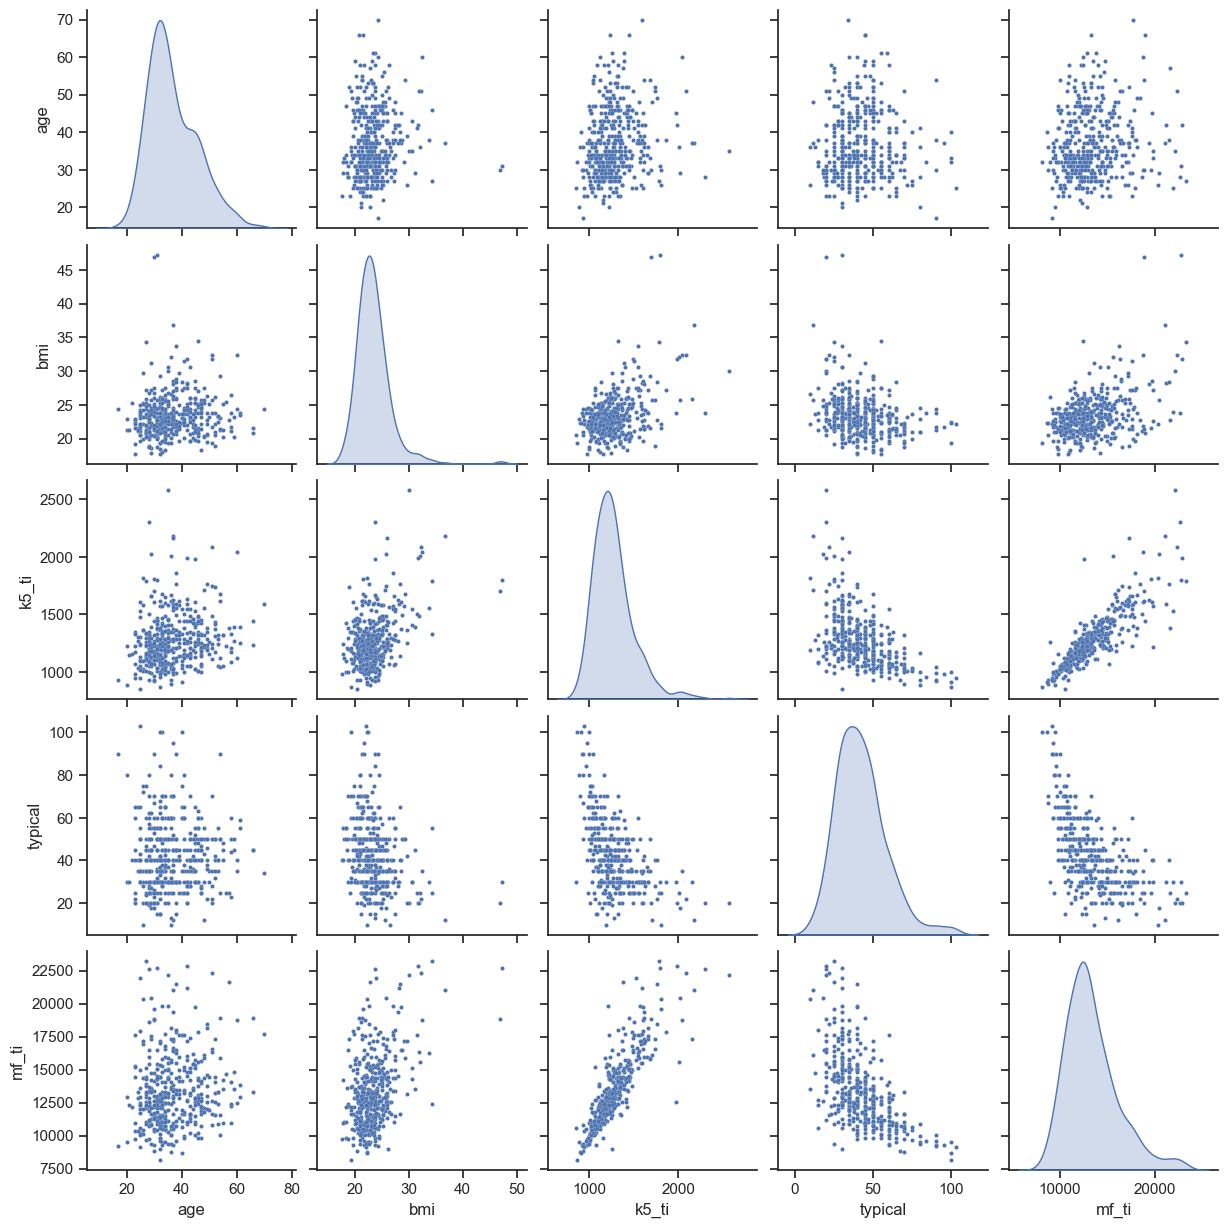

In [3]:
sns.set_theme(style='ticks')
sns.pairplot(runners, plot_kws=dict(marker='.', linewidth=.1), diag_kind='kde');

**Interpretacija grafa:** Iz grafa medsebojne odvisnosti med spremenljivkami lahko ocenimo da obstaja rahla korelacija med indeksom telesne mase in časom maratona, precej izrazita korelacija med časom na 5-kilometrski razdalji in časom maratona, ter inverzna korelacija me tedensko pretečeno razdaljo in časom maratona.

In [6]:
response = 'mf_ti'
base_features = ['age', 'bmi', 'typical', 'k5_ti']

included = []
remaining = base_features.copy()

**Definiranje funkcij za izvajanje MLR**

In [7]:
def generate_features(df, features):
    df_new = df.copy()
    for f in features:
        df_new[f'{f}^2'] = df_new[f] ** 2

    for f1, f2 in combinations(features, 2):
        df_new[f"{f1}*{f2}"] = df_new[f1] * df_new[f2]
    return df_new


def remove_outliers(df, response, predictors, threshold_multiplier=10):
    X = sm.add_constant(df[predictors])
    y = df[response]
    model = sm.OLS(y, X).fit()

    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    threshold = threshold_multiplier / len(df)
    mask = cooks_d < threshold
    print(f'Removed {len(df) - sum(mask)} outliers using Cook\'s distance (threshold: {threshold:.5f}')

    return df.loc[mask].copy()


def plot_cooks_distance(df, response, predictors, threshold_multiplier=10):
    X = sm.add_constant(df[predictors])
    y = df[response]
    model = sm.OLS(y, X).fit()
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]
    
    n = len(df)
    threshold = threshold_multiplier / n

    plt.figure(figsize=(10, 6))
    plt.stem(np.arange(n), cooks_d, markerfmt=",")
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.xlabel('Observation index')
    plt.ylabel("Cook's distance")
    plt.title("Cook's Distance for Influential Observations")
    plt.legend()
    plt.show()
    
    return cooks_d, threshold
    

def forward_stepwise(df, response, predictors):
    included = []
    best_r2 = -float('inf')
    while True:
        changed = False
        best_feature = None
        best_model = None

        for new_feature in set(predictors) - set(included):
            try:
                model = sm.OLS(df[response], sm.add_constant(df[included + [new_feature]])).fit()
                r2 = model.rsquared_adj
                if r2 > best_r2:
                    best_r2 = r2
                    best_feature = new_feature
                    best_model = model
            except:
                continue

        if best_feature is not None:
            included.append(best_feature)
            changed = True
            print(f"Added: {best_feature}, R^2: {best_r2:.4f}")

        if not changed:
            break

    final_model = sm.OLS(df[response], sm.add_constant(df[included])).fit()
    return final_model, included

#### 2. MLR model z vključevanjem samo linearnih členov modela

Najprej izvedemo MLR model na učni množici z vključevanjem samo linearnih členov.

In [8]:
final_model_1, selected_features_1 = forward_stepwise(train_df, response, base_features)

X_test_1 = sm.add_constant(test_df[selected_features_1])
y_test = test_df[response]
y_pred_1 = final_model_1.predict(X_test_1)

print("\nSelected Features:", selected_features_1)
print(final_model_1.summary())

Added: k5_ti, R^2: 0.7536
Added: typical, R^2: 0.7725
Added: bmi, R^2: 0.7756

Selected Features: ['k5_ti', 'typical', 'bmi']
                            OLS Regression Results                            
Dep. Variable:                  mf_ti   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     396.3
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          1.34e-110
Time:                        15:20:58   Log-Likelihood:                -2957.7
No. Observations:                 344   AIC:                             5923.
Df Residuals:                     340   BIC:                             5939.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

**Interpretacija:** S tem modelom pojasnimo 77.6% variabilnosti. Po koračni metodi smo dodajali spremenljivke, ki najbolj pojasnjujejo sprejemljivko $mf\_ti$. To smo storili z upoštevanjem $R^2_{adj}$. Najprej smo uporabili $5k\_ti$, potem smo dodali $typical$ in nato $bmi$. V zgornji tabeli lahko vidimo kako vplivajo različne spremenljivke. Če tek na 5km pretečemo eno sekundo počasneje, to pomeni 8 sekund počasneje na maratonski razdalji, če na teden pretečemo eno milijo več, to pomeni 30 sekund hitrejši čas na maratonu in če povečamo indeks telesne mase za ena, to pomeni skoraj minuto počasnejši čas na maratonu.
#### 3. MLR model z vključevanjem kombinacije členov

Potem izvedemo MLR model z vključevanjem kombinacije členov. Kot kombinacijo členov smo upoštevali tudi kombinacijo posameznega člena s samim seboj (na primer: $typical*typical$)

In [9]:
train_extended = generate_features(train_df, base_features)
test_extended = generate_features(test_df, base_features)
extended_features = [col for col in train_extended.columns if col != response]

final_model_2, selected_features_2 = forward_stepwise(train_extended, response, extended_features)

X_test_2 = sm.add_constant(test_extended[selected_features_2])
y_pred_2 = final_model_2.predict(X_test_2)

print("\nSelected Features:", selected_features_2)
print(final_model_2.summary())

Added: k5_ti, R^2: 0.7536
Added: k5_ti^2, R^2: 0.7762
Added: typical*k5_ti, R^2: 0.7876
Added: bmi*typical, R^2: 0.7935
Added: typical, R^2: 0.7940
Added: bmi^2, R^2: 0.7942
Added: bmi, R^2: 0.7950

Selected Features: ['k5_ti', 'k5_ti^2', 'typical*k5_ti', 'bmi*typical', 'typical', 'bmi^2', 'bmi']
                            OLS Regression Results                            
Dep. Variable:                  mf_ti   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     191.0
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          4.84e-113
Time:                        15:21:34   Log-Likelihood:                -2940.1
No. Observations:                 344   AIC:                             5896.
Df Residuals:                     336   BIC:                             5927.
Df Model:                           7                                 

**Interpretacija:** Z vklučevanjem polinomialnih členov in kombinacije členov lahko pojasnemo še dodatna 2% variabilnosti modela (79.5%). V model smo dodali poleg prejšnjih dodali še člene *$k5\_{ti}^2$, $bmi^2$, $typical*bmi$ in $typical*k5\_{ti}$*.

#### 4. Izločitev najbolj vplivnih točk s Cookovo razdaljo

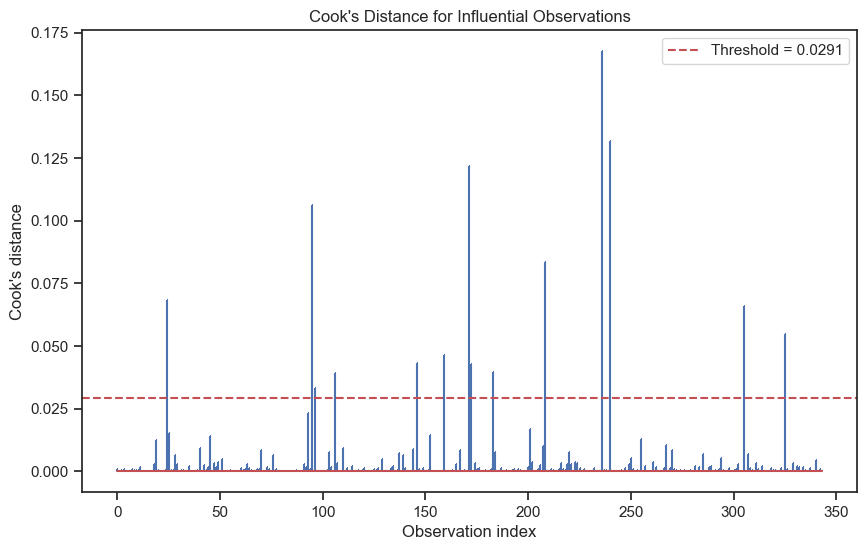

Removed 14 outliers using Cook's distance (threshold: 0.02907
Added: k5_ti, R^2: 0.7712
Added: k5_ti^2, R^2: 0.7888
Added: typical*k5_ti, R^2: 0.8001
Added: bmi*typical, R^2: 0.8037
Added: bmi, R^2: 0.8059

Selected Features: ['k5_ti', 'k5_ti^2', 'typical*k5_ti', 'bmi*typical', 'bmi']
                            OLS Regression Results                            
Dep. Variable:                  mf_ti   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     274.2
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          4.46e-114
Time:                        15:23:02   Log-Likelihood:                -2774.5
No. Observations:                 330   AIC:                             5561.
Df Residuals:                     324   BIC:                             5584.
Df Model:                           5                                         
Cov

In [10]:
plot_cooks_distance(train_extended, response, extended_features)
train_clean = remove_outliers(train_extended, response, extended_features)

final_model_3, selected_features_3 = forward_stepwise(train_clean, response, extended_features)

X_test_3 = sm.add_constant(test_extended[selected_features_3])
y_pred_3 = final_model_3.predict(X_test_3)

print('\nSelected Features:', selected_features_3)
print(final_model_3.summary())

**Intepretacija:** Točke odstopanja so od povprečja oddaljene največ, zato v modelu prinesejo največ k oceni parametrov regresije. Odstranimo jih s Cookovo razdaljo in dobimo izboljšan model, ki pojasni 80.6% variabilnosti modela. Popravljen model tako vsebuje naslednje člene: *$k5\_ti$, $k5\_ti^2$, $typical*k5\_ti$, $bmi*typical$*, $bmi$.

#### 5. Evaluacija modelov:

In [11]:
def evaluate_model(name, y_true, y_pred):
    r2 = np.corrcoef(y_true, y_pred)[0, 1] ** 2
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\n--- {name} ---")
    print(f"R² (test):    {r2:.4f}")
    print(f"RMSE (test):  {rmse:.2f}")
    print(f"MAE (test):   {mae:.2f}")

evaluate_model("Model 1: Linear Only", y_test, y_pred_1)
evaluate_model("Model 2: Extended Features", y_test, y_pred_2)
evaluate_model("Model 3: Outliers Removed", y_test, y_pred_3)


--- Model 1: Linear Only ---
R² (test):    0.6787
RMSE (test):  1507.76
MAE (test):   915.43

--- Model 2: Extended Features ---
R² (test):    0.6841
RMSE (test):  1510.20
MAE (test):   985.06

--- Model 3: Outliers Removed ---
R² (test):    0.6767
RMSE (test):  1519.90
MAE (test):   991.44


**Interpretacija:** na testnih podatkih modeli pričakovano delujejo slabše, saj teh podatkov še niso videl. V povprečju najboljši model (Model 2) pojasnjuje 68,4% variabilnosti. RMSE (root mean square error) veli, da se drugi model v povprečju zmoti za približno 1510 sekund pri napovedi časa maratona. V našem primeru najbolje deluje ravno drugi model.